In [1]:
import torch
from torch import nn

# Clasificación

La clasificación es un problema de predicción sobre si algo es una cosa u otra

## Preparación de datos

In [2]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise = 0.03, random_state=42)

print(f"Primeras 5 muestras de X: {X[:5]}")
print(f"Primeras 5 muestras de y: {y[:5]}")

Primeras 5 muestras de X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
Primeras 5 muestras de y: [1 1 1 1 0]


In [3]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


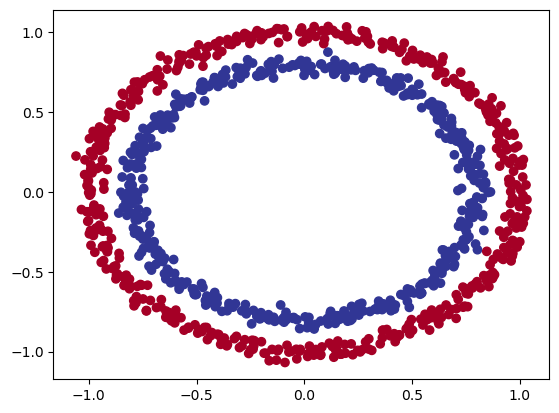

In [4]:
from matplotlib import pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap = plt.cm.RdYlBu)

## Input y output shapes

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
X_sample = X[0]
y_sample = y[0]

print(X_sample, y_sample)
print(X_sample.shape, y_sample.shape)
print(type(X))

[0.75424625 0.23148074] 1
(2,) ()
<class 'numpy.ndarray'>


In [7]:
# Pasamos los daros a tensores

import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [8]:
#Split data into training and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)

## Construcción del modelo

Construímos un modelo para clasificar los puntos azules y rojos. Para eso necesitamos:

1) Device agnostic code
2) Construir modelo usando nn.Module
3) Definir loss function y optimizador
4) Crear loop and test loop

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

2) Para construir el modelo:
- Hacemos una clase que herede nn.Module
- Creamos 2 layers de nn.Linear() que sean capaces de manejar los shapes de los datos
- Definimos el método forward()
- Instanciar el modelo

In [10]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
# replicamos usando nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5), 
    nn.Linear(in_features=5, out_features=1)
    ).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
#nueva manera de hacer el modelo:

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=5), 
            nn.Linear(in_features=5, out_features=1)
        )

    def forward(self, x):
        return self.two_linear_layers(x)
    
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [13]:
model_0.state_dict()

OrderedDict([('two_linear_layers.0.weight',
              tensor([[-0.0187,  0.1673],
                      [-0.4352,  0.6301],
                      [ 0.5440,  0.4866],
                      [ 0.5138,  0.6542],
                      [ 0.1837,  0.3677]])),
             ('two_linear_layers.0.bias',
              tensor([ 0.0923, -0.0119, -0.4846, -0.3121,  0.2274])),
             ('two_linear_layers.1.weight',
              tensor([[ 0.0605,  0.1037, -0.2901, -0.2836, -0.2932]])),
             ('two_linear_layers.1.bias', tensor([-0.2616]))])

In [14]:
#make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: \n{untrained_preds[:10]}")
print(f"\nFirst 10 labels: \n{y_test[:10]}")



Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
tensor([[-0.1884],
        [-0.4457],
        [ 0.3019],
        [-0.3266],
        [ 0.0097],
        [-0.1450],
        [-0.6378],
        [-0.5682],
        [ 0.3134],
        [-0.4661]])

First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


3) Definir loss function y optimizador

    Qué Loss Function usamos? Para clasificación se usa Binary Cross Entropy o Categorical Cross Entropy

    Como este problema es clasificación binaria, usamos Binary Cross Entropy

In [15]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [16]:
# Calcular precisión

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

#### Logits

Nos referimos a Logits como la salida en crudo de nuestro modelo. Podemos convertirlos en predicciones de probabilidades pasandolos por una función de activación (ejemplos: Sigmoid o Softmax)

Luego los convertimos en predicción de probabilidades a prediction labels al redondearlos o tomando argmax()

Model Output -> Sigmoid activation -> round

In [18]:
model_0.eval()

with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1884],
        [-0.4457],
        [ 0.3019],
        [-0.3266],
        [ 0.0097]])

In [19]:
#sigmoid activation function

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4530],
        [0.3904],
        [0.5749],
        [0.4191],
        [0.5024]])

In [22]:
y_preds = torch.round(y_pred_probs).squeeze()
y_preds

tensor([0., 0., 1., 0., 1.])

Para la loss function que elegimos hay que pasar los logits, ya que esa función integra el sigmoid y es mas estable.

4) Entrenar modelo: Construir testing y training loop

Train loop:

-   Forward pass
-   Calcular error
-   Optimizer zero grad
-   Loss backward
-   Optimizer step

In [27]:
#training and test loop

torch.manual_seed(42)

epochs = 100

X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Training
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)   #nn.BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # Testing

    model_0.eval()

    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f}, Acc: {acc:.2f}% | Test loss: {test_loss:.2f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69, Acc: 49.88% | Test loss: 0.69, Test acc: 47.00%
Epoch: 10 | Loss: 0.69, Acc: 49.75% | Test loss: 0.69, Test acc: 47.00%
Epoch: 20 | Loss: 0.69, Acc: 50.50% | Test loss: 0.69, Test acc: 46.50%
Epoch: 30 | Loss: 0.69, Acc: 50.00% | Test loss: 0.69, Test acc: 47.50%
Epoch: 40 | Loss: 0.69, Acc: 49.62% | Test loss: 0.69, Test acc: 48.50%
Epoch: 50 | Loss: 0.69, Acc: 50.00% | Test loss: 0.69, Test acc: 49.00%
Epoch: 60 | Loss: 0.69, Acc: 49.12% | Test loss: 0.69, Test acc: 50.50%
Epoch: 70 | Loss: 0.69, Acc: 48.88% | Test loss: 0.69, Test acc: 51.50%
Epoch: 80 | Loss: 0.69, Acc: 49.00% | Test loss: 0.69, Test acc: 52.50%
Epoch: 90 | Loss: 0.69, Acc: 49.00% | Test loss: 0.69, Test acc: 51.50%
Epoch: 100 | Loss: 0.69, Acc: 49.38% | Test loss: 0.69, Test acc: 50.00%
Epoch: 110 | Loss: 0.69, Acc: 49.38% | Test loss: 0.69, Test acc: 49.50%
Epoch: 120 | Loss: 0.69, Acc: 49.75% | Test loss: 0.69, Test acc: 50.00%
Epoch: 130 | Loss: 0.69, Acc: 50.00% | Test loss: 0.69, Test a

### Evaluación del modelo

In [28]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


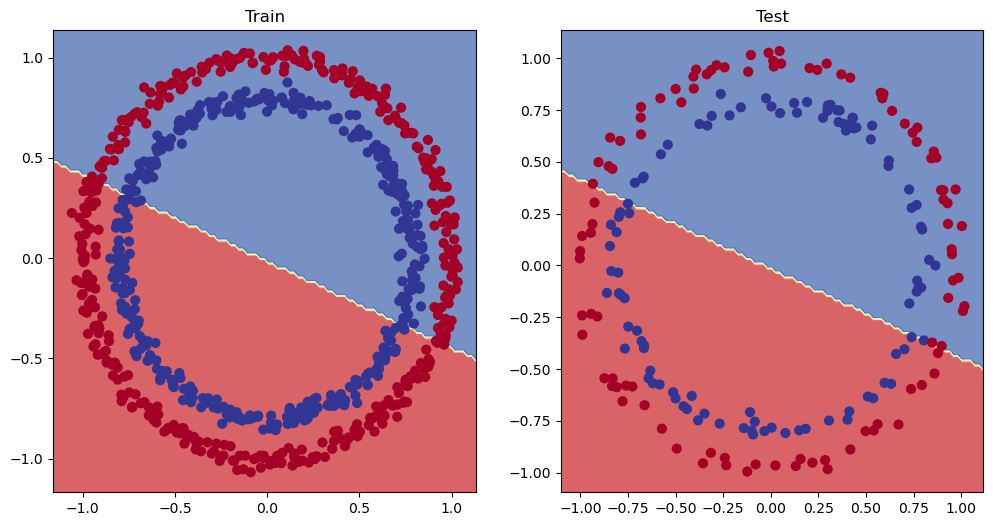

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

plt.show()

## Mejorando el modelo

Opciones: 
-   Añadir capas
-   Añadir neuronas
-   Cambiar la función de activación
-   Mas epochs
-   Cambiar lr
-   Cambiar loss function

Estas cosas se llaman hiperparámetros ya que son valores que nosotros podemos modificar.

Mejoramos:
-   Añadimos neuronas: 5 -> 10
-   Numero de capas: 2 -> 3
-   Aumentar epochs: 100 -> 1000

Siempre es mejor probar las mejoras una por una en lugar de todas juntas

In [30]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, X):
        z = self.layer_1(X)
        z = self.layer_2(z)
        z = self.layer_3(z)

        return z

In [31]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

#### Entrenamiento y testing

In [33]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

#training and test loop

torch.manual_seed(42)

epochs = 1000

X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Training
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)   #nn.BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # Testing

    model_1.eval()

    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f}, Acc: {acc:.2f}% | Test loss: {test_loss:.2f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69, Acc: 50.88% | Test loss: 0.69, Test acc: 51.00%
Epoch: 100 | Loss: 0.69, Acc: 50.38% | Test loss: 0.69, Test acc: 48.00%
Epoch: 200 | Loss: 0.69, Acc: 51.12% | Test loss: 0.69, Test acc: 46.00%
Epoch: 300 | Loss: 0.69, Acc: 51.62% | Test loss: 0.69, Test acc: 45.00%
Epoch: 400 | Loss: 0.69, Acc: 51.12% | Test loss: 0.69, Test acc: 46.00%
Epoch: 500 | Loss: 0.69, Acc: 51.00% | Test loss: 0.69, Test acc: 46.00%
Epoch: 600 | Loss: 0.69, Acc: 51.00% | Test loss: 0.69, Test acc: 46.00%
Epoch: 700 | Loss: 0.69, Acc: 51.00% | Test loss: 0.69, Test acc: 46.00%
Epoch: 800 | Loss: 0.69, Acc: 51.00% | Test loss: 0.69, Test acc: 46.00%
Epoch: 900 | Loss: 0.69, Acc: 51.00% | Test loss: 0.69, Test acc: 46.00%


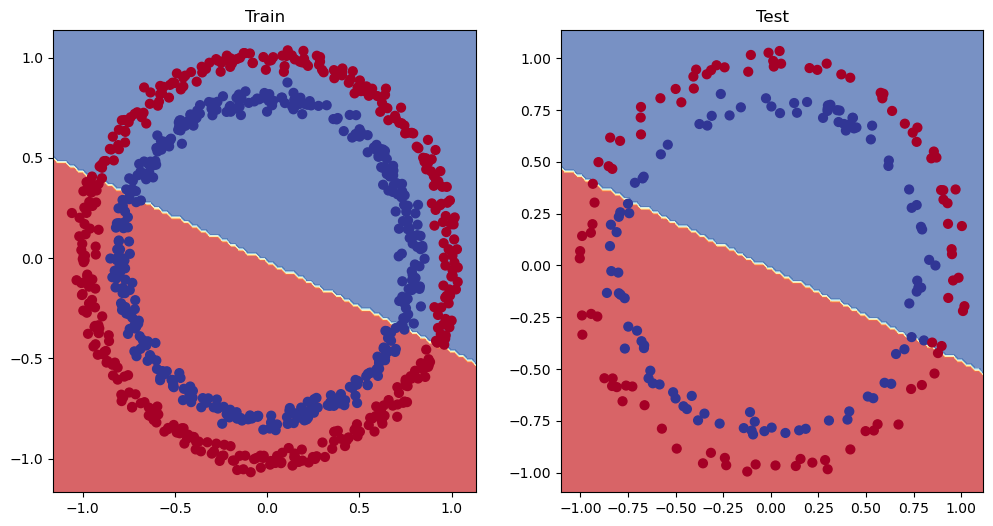

In [35]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

plt.show()